In [1]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.1.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:4 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [2]:
# Start Spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("LoadingData").getOrCreate()

In [3]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://spot-i-fy-bucket.s3.us-east-2.amazonaws.com/tracks.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("tracks.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+--------------------+--------------------+----------+-----------+--------+-------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|                  id|                name|popularity|duration_ms|explicit|            artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|
+--------------------+--------------------+----------+-----------+--------+-------------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+
|35iwgR4jXetI318WE...|               Carve|         6|     126903|       0|            ['Uli']|['45tIt06XoI0Iio4...|  1922-02-22|       0.645| 0.445|  0| -13.338|   1|      0.451|       0.674|           0.744|   0.151|  0.127|104.851|             3|


In [4]:
# Print our schema
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: string (nullable = true)
 |-- duration_ms: string (nullable = true)
 |-- explicit: string (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: string (nullable = true)
 |-- energy: string (nullable = true)
 |-- key: string (nullable = true)
 |-- loudness: string (nullable = true)
 |-- mode: string (nullable = true)
 |-- speechiness: string (nullable = true)
 |-- acousticness: string (nullable = true)
 |-- instrumentalness: string (nullable = true)
 |-- liveness: string (nullable = true)
 |-- valence: string (nullable = true)
 |-- tempo: string (nullable = true)
 |-- time_signature: string (nullable = true)



In [5]:
# Read in data from S3 Buckets
from pyspark import SparkFiles
url = "https://spot-i-fy-bucket.s3.us-east-2.amazonaws.com/artists.csv"
spark.sparkContext.addFile(url)
a_df = spark.read.csv(SparkFiles.get("artists.csv"), sep=",", header=True)

# Show DataFrame
a_df.show()

+--------------------+---------+------+--------------------+----------+
|                  id|followers|genres|                name|popularity|
+--------------------+---------+------+--------------------+----------+
|0DheY5irMjBUeLybb...|      0.0|    []|Armid & Amir Zare...|         0|
|0DlhY15l3wsrnlfGi...|      5.0|    []|         ปูนา ภาวิณี|         0|
|0DmRESX2JknGPQyO1...|      0.0|    []|               Sadaa|         0|
|0DmhnbHjm1qw6NCYP...|      0.0|    []|           Tra'gruda|         0|
|0Dn11fWM7vHQ3rinv...|      2.0|    []|Ioannis Panoutsop...|         0|
|0DotfDlYMGqkbzfBh...|      7.0|    []|       Astral Affect|         0|
|0DqP3bOCiC48L8SM9...|      1.0|    []|           Yung Seed|         0|
|0Drs3maQb99iRglyT...|      0.0|    []|               Wi'Ma|         0|
|0DsPeAi1gxPPnYjgp...|      0.0|    []|             lentboy|         0|
|0DtvnTxgZ9K5YaPS5...|     20.0|    []|            addworks|         0|
|0Du4t8UK1lBD8TnOI...|      1.0|    []|         Harrbazzter|    

In [6]:
# Import dependencies for Machine Learning
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster, linkage, dendrogram
import pandas as pd
import numpy as np
from pathlib import Path
#import hvplot.pandas
#from path import Path
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.metrics import confusion_matrix

In [7]:
# Convert Spark DataFrame to Pandas DataFrame
artists_df = a_df.toPandas()
artists_df.head()

,id,followers,genres,name,popularity
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0


In [8]:
# Convert Spark DataFrame to Pandas DataFrame
track_df = df.toPandas()
track_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.263,0,-22.136,1,0.957,0.797,0.0,0.148,0.655,102.009,1
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.177,1,-21.18,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918,0.104,0.397,169.98,3
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.158,3,-16.9,0,0.039,0.989,0.13,0.311,0.196,103.22,4


In [9]:
artists_df['artists'] = artists_df['name']
artists_df.head()

,id,followers,genres,name,popularity,artists
0,0DheY5irMjBUeLybbCUEZ2,0.0,[],Armid & Amir Zare Pashai feat. Sara Rouzbehani,0,Armid & Amir Zare Pashai feat. Sara Rouzbehani
1,0DlhY15l3wsrnlfGio2bjU,5.0,[],ปูนา ภาวิณี,0,ปูนา ภาวิณี
2,0DmRESX2JknGPQyO15yxg7,0.0,[],Sadaa,0,Sadaa
3,0DmhnbHjm1qw6NCYPeZNgJ,0.0,[],Tra'gruda,0,Tra'gruda
4,0Dn11fWM7vHQ3rinvWEl4E,2.0,[],Ioannis Panoutsopoulos,0,Ioannis Panoutsopoulos


In [10]:
# Merge the two dataframes
# How to merge when columns have different name
music_df = track_df.merge(artists_df, how='left')
music_df.head()

,id,name,popularity,duration_ms,explicit,artists,id_artists,release_date,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres
0,35iwgR4jXetI318WEWsa1Q,Carve,6,126903,0,['Uli'],['45tIt06XoI0Iio4LBEVpls'],1922-02-22,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3,NaN,NaN
1,021ht4sdgPcrDgSk7JTbKY,Capítulo 2.16 - Banquero Anarquista,0,98200,0,['Fernando Pessoa'],['14jtPCOoNZwquk5wd9DxrY'],1922-06-01,0.695,0.263,0,-22.136,1,0.957,0.797,0.0,0.148,0.655,102.009,1,NaN,NaN
2,07A5yehtSnoedViJAZkNnc,Vivo para Quererte - Remasterizado,0,181640,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.434,0.177,1,-21.18,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5,NaN,NaN
3,08FmqUhxtyLTn6pAh6bk45,El Prisionero - Remasterizado,0,176907,0,['Ignacio Corsini'],['5LiOoJbxVSAMkBS2fUm3X2'],1922-03-21,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918,0.104,0.397,169.98,3,NaN,NaN
4,08y9GfoqCWfOGsKdwojr5e,Lady of the Evening,0,163080,0,['Dick Haymes'],['3BiJGZsyX9sJchTqcSA7Su'],1922,0.402,0.158,3,-16.9,0,0.039,0.989,0.13,0.311,0.196,103.22,4,NaN,NaN


In [11]:
# Exploratory Data to understand how we need to preprocess
# Explore popularity range - over 75? over 50?
music_df.dtypes

id                  object
name                object
popularity          object
duration_ms         object
explicit            object
artists             object
id_artists          object
release_date        object
danceability        object
energy              object
key                 object
loudness            object
mode                object
speechiness         object
acousticness        object
instrumentalness    object
liveness            object
valence             object
tempo               object
time_signature      object
followers           object
genres              object
dtype: object

In [12]:
# Preprocessing
# Drop columns that won't be useful to clustering that might predict genre
# Maybe keep duration, maybe try sampling for dendrogram
spotify_df = music_df.drop(columns=['id', 'name', 'duration_ms', 'explicit', 'artists', 'release_date', 'followers', 'genres', 'id_artists'])
spotify_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,6,0.645,0.445,0,-13.338,1,0.451,0.674,0.744,0.151,0.127,104.851,3
1,0,0.695,0.263,0,-22.136,1,0.957,0.797,0.0,0.148,0.655,102.009,1
2,0,0.434,0.177,1,-21.18,1,0.0512,0.994,0.0218,0.212,0.457,130.418,5
3,0,0.321,0.0946,7,-27.961,1,0.0504,0.995,0.918,0.104,0.397,169.98,3
4,0,0.402,0.158,3,-16.9,0,0.039,0.989,0.13,0.311,0.196,103.22,4


In [13]:
# Convert to numeric data
cols = ['popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'key', 'mode', 'time_signature']
spotify_df[cols] = spotify_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

In [14]:
# Filter table by tracks with popularity above 50
spotify_df = spotify_df[spotify_df['popularity'] >= 50]
spotify_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1857,51.0,0.515,0.2220,0.0,-16.918,0.0,0.0575,0.821,0.001930,0.190,0.350,98.358,4.0
3857,51.0,0.626,0.7440,2.0,-9.189,0.0,0.0662,0.847,0.892000,0.145,0.259,113.117,4.0
4857,55.0,0.673,0.3770,0.0,-14.141,1.0,0.0697,0.586,0.000000,0.332,0.713,88.973,4.0
6505,50.0,0.482,0.2870,1.0,-9.108,0.0,0.0482,0.981,0.000017,0.300,0.536,69.804,4.0
8095,65.0,0.504,0.0644,2.0,-14.754,0.0,0.0408,0.972,0.000004,0.174,0.403,106.994,5.0


In [15]:
# Drop null values
spotify_df = spotify_df.dropna()
spotify_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
1857,51.0,0.515,0.2220,0.0,-16.918,0.0,0.0575,0.821,0.001930,0.190,0.350,98.358,4.0
3857,51.0,0.626,0.7440,2.0,-9.189,0.0,0.0662,0.847,0.892000,0.145,0.259,113.117,4.0
4857,55.0,0.673,0.3770,0.0,-14.141,1.0,0.0697,0.586,0.000000,0.332,0.713,88.973,4.0
6505,50.0,0.482,0.2870,1.0,-9.108,0.0,0.0482,0.981,0.000017,0.300,0.536,69.804,4.0
8095,65.0,0.504,0.0644,2.0,-14.754,0.0,0.0408,0.972,0.000004,0.174,0.403,106.994,5.0


In [16]:
# Use Hierarchical clustering
# Normalize data
from sklearn.preprocessing import normalize
data_scaled = normalize(spotify_df)
data_scaled = pd.DataFrame(data_scaled, columns=spotify_df.columns)
data_scaled.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
0,0.454729,0.004592,0.001979,0.000000,-0.150845,0.000000,0.000513,0.007320,1.720838e-05,0.001694,0.003121,0.876985,0.035665
1,0.409596,0.005028,0.005975,0.016063,-0.073800,0.000000,0.000532,0.006803,7.163920e-03,0.001165,0.002080,0.908477,0.032125
2,0.520638,0.006371,0.003569,0.000000,-0.133861,0.009466,0.000660,0.005547,0.000000e+00,0.003143,0.006749,0.842232,0.037865
3,0.578345,0.005575,0.003320,0.011567,-0.105351,0.000000,0.000558,0.011347,1.966375e-07,0.003470,0.006200,0.807417,0.046268
4,0.515147,0.003994,0.000510,0.015851,-0.116930,0.000000,0.000323,0.007703,3.455446e-08,0.001379,0.003194,0.847963,0.039627


In [17]:
import plotly.figure_factory as ff

In [18]:
# Take sample of scaled spotify data for dendrogram
sample_df = data_scaled.sample(n = 500)
sample_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
48354,0.449506,0.001340,0.007271,0.079325,-0.075314,0.000000,0.000428,0.000013,4.001484e-04,0.007915,0.002979,0.885782,0.035255
12376,0.487555,0.007111,0.005050,0.064394,-0.092829,0.009199,0.000390,0.002042,9.070364e-06,0.000975,0.006504,0.864849,0.036797
44792,0.389566,0.004449,0.005152,0.062833,-0.039478,0.006283,0.000527,0.000754,0.000000e+00,0.000823,0.004109,0.917603,0.025133
14405,0.272832,0.002996,0.003650,0.054566,-0.029411,0.005457,0.000211,0.000200,1.364161e-08,0.000557,0.003716,0.959780,0.021827
62605,0.434087,0.004598,0.004275,0.066217,-0.040216,0.007357,0.000263,0.001405,2.626592e-08,0.000861,0.002332,0.897206,0.022072


In [19]:
# Create the dendrogram
fig = ff.create_dendrogram(sample_df, color_threshold=0)
fig.update_layout(width=800, height=500)
fig.show()

In [20]:
# Create hierarchal clustering array using n_clusters determined from dendrogram analysis
from sklearn.cluster import AgglomerativeClustering
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')  
cluster.fit_predict(sample_df)

array([2, 5, 0, 4, 2, 2, 0, 0, 5, 2, 5, 0, 4, 4, 0, 6, 0, 3, 2, 0, 2, 0,
       0, 5, 0, 3, 5, 0, 2, 2, 0, 4, 0, 0, 5, 0, 6, 4, 2, 6, 6, 3, 6, 0,
       0, 5, 2, 0, 0, 0, 0, 2, 4, 5, 7, 5, 0, 0, 2, 2, 5, 6, 2, 0, 4, 4,
       0, 2, 4, 6, 5, 4, 5, 6, 2, 0, 5, 5, 2, 5, 5, 0, 5, 0, 4, 0, 0, 5,
       0, 0, 4, 0, 4, 0, 2, 0, 0, 1, 2, 5, 5, 2, 2, 5, 0, 2, 0, 4, 2, 0,
       0, 2, 0, 2, 0, 0, 4, 5, 1, 6, 0, 0, 0, 6, 6, 0, 2, 0, 4, 2, 0, 4,
       0, 6, 0, 4, 2, 4, 0, 1, 6, 5, 4, 2, 6, 4, 0, 5, 6, 4, 2, 0, 0, 5,
       2, 0, 5, 0, 2, 2, 0, 2, 0, 5, 1, 4, 5, 2, 4, 2, 2, 0, 5, 0, 0, 0,
       1, 0, 5, 0, 0, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 5, 2, 4, 3,
       5, 5, 5, 1, 0, 5, 4, 0, 0, 0, 0, 0, 2, 2, 5, 5, 4, 2, 2, 0, 0, 5,
       0, 0, 5, 2, 5, 0, 2, 2, 0, 2, 0, 0, 5, 5, 5, 2, 0, 4, 5, 5, 3, 2,
       5, 5, 0, 2, 2, 0, 0, 0, 2, 0, 2, 4, 2, 2, 5, 0, 5, 6, 0, 4, 0, 0,
       5, 5, 4, 0, 0, 1, 0, 3, 0, 4, 0, 5, 0, 6, 2, 4, 0, 6, 4, 6, 6, 1,
       2, 5, 6, 6, 0, 0, 0, 3, 0, 2, 4, 2, 5, 2, 5,

In [21]:
# add class column to sample
sample_df["class"] = cluster.labels_
sample_df.head()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,class
48354,0.449506,0.001340,0.007271,0.079325,-0.075314,0.000000,0.000428,0.000013,4.001484e-04,0.007915,0.002979,0.885782,0.035255,2
12376,0.487555,0.007111,0.005050,0.064394,-0.092829,0.009199,0.000390,0.002042,9.070364e-06,0.000975,0.006504,0.864849,0.036797,5
44792,0.389566,0.004449,0.005152,0.062833,-0.039478,0.006283,0.000527,0.000754,0.000000e+00,0.000823,0.004109,0.917603,0.025133,0
14405,0.272832,0.002996,0.003650,0.054566,-0.029411,0.005457,0.000211,0.000200,1.364161e-08,0.000557,0.003716,0.959780,0.021827,4
62605,0.434087,0.004598,0.004275,0.066217,-0.040216,0.007357,0.000263,0.001405,2.626592e-08,0.000861,0.002332,0.897206,0.022072,2


In [28]:
#Import hvplot
!pip install -U hvplot

     |████████████████████████████████| 3.1 MB 5.2 MB/s 


In [30]:
#import holoviews as hv
#hv.extension('bokeh')
#import hvplot.pandas

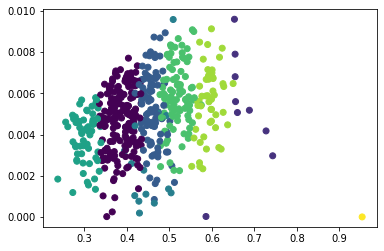

In [31]:
plt.scatter(sample_df["popularity"], sample_df["energy"], c=sample_df["class"])

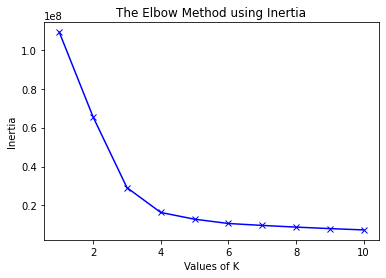

In [34]:
#K Means Clustering
#Begin with elbow graph to determine how many clusters we might want
inertia = []
k = list(range(1, 11))
# Calculate the inertia for the range of K values
for i in k:
   km = KMeans(n_clusters=i, random_state=0)
   km.fit(spotify_df)
   inertia.append(km.inertia_)
#Create elbow curve in hvPlot
elbow_data = {"k":k, "inertia":inertia}
df_elbow = pd.DataFrame(elbow_data)
#df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")
plt.plot(k, inertia, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [53]:
# Set X 
X = sample_df
X_scaled = X
X_scaled

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,class
48354,0.449506,0.001340,0.007271,0.079325,-0.075314,0.000000,0.000428,0.000013,4.001484e-04,0.007915,0.002979,0.885782,0.035255,2
12376,0.487555,0.007111,0.005050,0.064394,-0.092829,0.009199,0.000390,0.002042,9.070364e-06,0.000975,0.006504,0.864849,0.036797,5
44792,0.389566,0.004449,0.005152,0.062833,-0.039478,0.006283,0.000527,0.000754,0.000000e+00,0.000823,0.004109,0.917603,0.025133,0
14405,0.272832,0.002996,0.003650,0.054566,-0.029411,0.005457,0.000211,0.000200,1.364161e-08,0.000557,0.003716,0.959780,0.021827,4
62605,0.434087,0.004598,0.004275,0.066217,-0.040216,0.007357,0.000263,0.001405,2.626592e-08,0.000861,0.002332,0.897206,0.022072,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19392,0.440175,0.005633,0.006700,0.082066,-0.015302,0.000000,0.000241,0.001805,1.081785e-06,0.001074,0.007207,0.893450,0.029842,2
53093,0.446305,0.005370,0.004704,0.000000,-0.052593,0.007084,0.000302,0.000038,1.423925e-06,0.000587,0.004718,0.892815,0.028337,2
67312,0.409837,0.004255,0.006997,0.052161,-0.031461,0.007452,0.000441,0.000364,0.000000e+00,0.003085,0.004881,0.909548,0.029806,0
9428,0.330777,0.002430,0.002736,0.048113,-0.049683,0.000000,0.000192,0.004637,0.000000e+00,0.000568,0.002189,0.940843,0.024056,4


In [54]:
# Create K Means Model with X clusters (from elbow plot)
model = KMeans(n_clusters=5, random_state=42).fit(X_scaled)
model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [56]:
# Calculate predicted values.
y_pred = model.predict(X_scaled)
y_pred

array([2, 0, 1, 3, 2, 2, 1, 1, 0, 2, 0, 1, 3, 3, 1, 4, 1, 2, 2, 1, 2, 1,
       1, 0, 1, 2, 0, 1, 2, 2, 1, 3, 1, 1, 0, 1, 4, 3, 2, 4, 4, 2, 4, 1,
       1, 0, 2, 1, 1, 1, 1, 2, 3, 0, 4, 0, 1, 1, 2, 2, 0, 4, 2, 1, 3, 3,
       1, 2, 3, 4, 0, 3, 0, 4, 2, 1, 0, 0, 2, 0, 0, 1, 0, 1, 3, 1, 1, 0,
       1, 1, 3, 1, 3, 1, 2, 1, 1, 1, 2, 0, 0, 2, 2, 0, 1, 2, 1, 3, 2, 1,
       1, 2, 1, 2, 1, 1, 3, 0, 1, 4, 1, 1, 1, 4, 4, 1, 2, 1, 3, 2, 1, 3,
       1, 4, 1, 3, 2, 3, 1, 1, 4, 0, 3, 2, 4, 3, 1, 0, 4, 3, 2, 1, 1, 0,
       2, 1, 0, 1, 2, 2, 1, 2, 1, 0, 1, 3, 0, 2, 3, 2, 2, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 0, 2, 3, 2,
       0, 0, 0, 1, 1, 0, 3, 1, 1, 1, 1, 1, 2, 2, 0, 0, 3, 2, 2, 1, 1, 0,
       1, 1, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 0, 0, 0, 2, 1, 3, 0, 0, 2, 2,
       0, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2, 3, 2, 2, 0, 1, 0, 4, 1, 3, 1, 1,
       0, 0, 3, 1, 1, 1, 1, 2, 1, 3, 1, 0, 1, 4, 2, 3, 1, 4, 3, 4, 4, 1,
       2, 0, 4, 4, 1, 1, 1, 2, 1, 2, 3, 2, 0, 2, 0,

In [67]:
# Add predicted values onto the original dataframe
sample_df["Cluster"] = y_pred
sample_df


,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,class,Cluster
48354,0.449506,0.001340,0.007271,0.079325,-0.075314,0.000000,0.000428,0.000013,4.001484e-04,0.007915,0.002979,0.885782,0.035255,2,2
12376,0.487555,0.007111,0.005050,0.064394,-0.092829,0.009199,0.000390,0.002042,9.070364e-06,0.000975,0.006504,0.864849,0.036797,5,0
44792,0.389566,0.004449,0.005152,0.062833,-0.039478,0.006283,0.000527,0.000754,0.000000e+00,0.000823,0.004109,0.917603,0.025133,0,1
14405,0.272832,0.002996,0.003650,0.054566,-0.029411,0.005457,0.000211,0.000200,1.364161e-08,0.000557,0.003716,0.959780,0.021827,4,3
62605,0.434087,0.004598,0.004275,0.066217,-0.040216,0.007357,0.000263,0.001405,2.626592e-08,0.000861,0.002332,0.897206,0.022072,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19392,0.440175,0.005633,0.006700,0.082066,-0.015302,0.000000,0.000241,0.001805,1.081785e-06,0.001074,0.007207,0.893450,0.029842,2,2
53093,0.446305,0.005370,0.004704,0.000000,-0.052593,0.007084,0.000302,0.000038,1.423925e-06,0.000587,0.004718,0.892815,0.028337,2,2
67312,0.409837,0.004255,0.006997,0.052161,-0.031461,0.007452,0.000441,0.000364,0.000000e+00,0.003085,0.004881,0.909548,0.029806,0,1
9428,0.330777,0.002430,0.002736,0.048113,-0.049683,0.000000,0.000192,0.004637,0.000000e+00,0.000568,0.002189,0.940843,0.024056,4,3


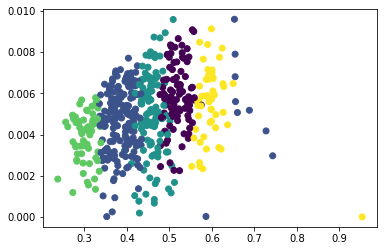

In [68]:
# Plot clusters
# Create a scatterplot of combined DataFrame
plt.scatter(sample_df["popularity"], sample_df["energy"], c=sample_df["Cluster"])
